## Task 3. Data assimilation

# 1. Imports and loading observed data

In [16]:
import numpy as np
import pickle
from pathlib import Path
import time
import torch
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary
from torcheval import metrics
import torch.nn as nn
from numpy.linalg import inv
from VAE_model import VAE

In [17]:
obs_dataset = np.load("data/Ferguson_fire_obs.npy")

# 2. Loading the models from Task 1 and 2 and generating predictions

## 2.1 Task 1 Model RNN

()

## 2.2 Task 2 CVAE

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# class VAE(nn.Module):
#     def __init__(self, latent_dim = 64, channel_size = 9,latent_pixel_size = 16):
#         super(VAE, self).__init__()
#         self.encoder = nn.Sequential(
            
#             nn.Conv3d(1, 8, kernel_size=(5,6,6), stride=(1,2,2), padding=(2,2,2)),  # Example for 3D conv layer
#             nn.LeakyReLU(),
#             nn.Conv3d(8, 4, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
#             nn.LeakyReLU(),
#             nn.Conv3d(4,1, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
        
        
#             nn.LeakyReLU(),
    

#             nn.Flatten(),
#             nn.Linear(latent_pixel_size*latent_pixel_size*channel_size,256),
#             nn.LeakyReLU(),
#             nn.Dropout(),
            
#         )
#         ### Latent space transformations

#         self.mu = nn.Linear(256,latent_dim)
#         self.logvar = nn.Linear(256,latent_dim)
        
        
#         self.decoder = nn.Sequential(
            
#             nn.Linear(latent_dim, 256),

#             nn.LeakyReLU(),
#             nn.Linear(256,latent_pixel_size*latent_pixel_size*channel_size),
#             nn.Unflatten(1,(1,channel_size,latent_pixel_size,latent_pixel_size)),

#             nn.ConvTranspose3d(1,4, kernel_size = (3,4,4), stride= (1,2,2), padding = 1),
#             nn.LeakyReLU(),
#             nn.ConvTranspose3d(4, 8, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
#             nn.LeakyReLU(),
#             nn.ConvTranspose3d(8, 1, kernel_size=(5,6,6), stride=(1,2,2), padding=2),

#             nn.Sigmoid()
#         )

#     def encode(self, x):
#         x = self.encoder(x)
#         mu = self.mu(x)
#         logvar = self.logvar(x)
        
#         return mu, logvar
        
#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)  # Calculate standard deviation from log variance
#         eps = torch.randn_like(std)
#         return mu + eps * std
        
#     def decode(self, x):
#         return self.decoder(x)

#     def forward(self, x):
#         mu, logvar = self.encode(x)
#         z = self.reparameterize(mu, logvar)
#         z = self.decode(z)
#         assert z.shape == x.shape
#         return z, mu, logvar


In [19]:
model_path = 'data/model.pth'
model_CVAE = torch.load(model_path, map_location=torch.device('cpu'))
model_CVAE = model_CVAE.to(device)  # Ensure the model is moved to the correct device

We generate 10 images and chose the sixth one:

In [10]:
nums = (torch.randn((2,16))).to(device)
samples = model_CVAE.decode(nums).cpu().detach().numpy()

In [11]:
split_size = 5

In [12]:
channel_size = 100//split_size -1

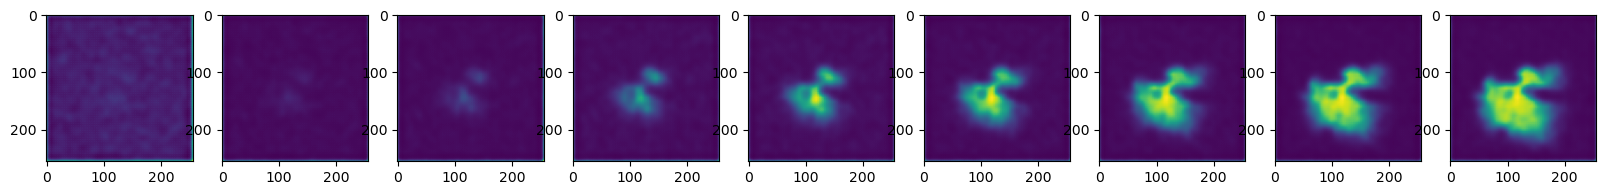

In [13]:
fig ,ax = plt.subplots(1,9, figsize = (20,10))
for i in range(9):
        ax[i].imshow(samples[0].reshape(1,channel_size,256,256)[0][i*2])

plt.show()

In [14]:
generated_image = samples[0].reshape(1,channel_size,256,256)[0][17]

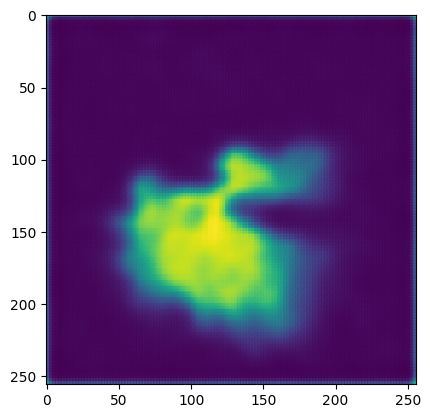

In [ ]:
plt.imshow(generated_image)

In [ ]:
observed_image = obs_dataset[3]

In [ ]:
observed_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 3. Compressing the data

We use the trained autoencoder

In [ ]:
class CAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        padding = 1
        output_padding =0


        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=5, stride=1, padding= 2),
            torch.nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.MaxPool2d(2,2),
            torch.nn.LeakyReLU(True),

            torch.nn.Conv2d(16, 1, kernel_size=3, stride=2, padding=1),
            torch.nn.LeakyReLU(True),

        )

        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.LeakyReLU(True),
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1, output_padding=0),
            torch.nn.ConvTranspose2d(8, 1, kernel_size=5, stride=1, padding=2, output_padding=output_padding),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.view(-1,1,256,256)

In [ ]:
model_CAE = CAE()
model_CAE.load_state_dict(torch.load('/content/drive/My Drive/CAEGroup.pth'))
model_CAE = model_CAE.to(device)  # Ensure the model is moved to the correct device

In [ ]:
sensors_tensor = torch.tensor(observed_image, dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)
generated_tensor = torch.tensor(generated_image, dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)

In [ ]:
sensors_tensor.shape

torch.Size([1, 1, 256, 256])

In [ ]:
generated_tensor.shape

torch.Size([1, 1, 256, 256])

In [ ]:
# observed_image_flat = observed_image.flatten()
R_physical = np.cov(observed_image)

In [ ]:
R_physical_tensor = torch.tensor(R_physical, dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)

In [ ]:
R_physical_tensor.shape

torch.Size([1, 1, 256, 256])

In [ ]:
with torch.no_grad():
    R_encoded = model_CAE.encoder(R_physical_tensor).cpu().numpy()

print("Shape of encoded R:", R_encoded.shape)

Shape of encoded R: (1, 1, 64, 64)


In [ ]:
R_encoded = R_encoded.reshape(64,64)

In [ ]:
model_CAE.eval()
with torch.no_grad():
    encoded_sensor_data = model_CAE.encoder(sensors_tensor)
    encoded_sensor_data = encoded_sensor_data.cpu().numpy()
    encoded_model_data = model_CAE.encoder(generated_tensor)
    encoded_model_data = encoded_model_data.cpu().numpy()

print("Shape of encoded data:", encoded_sensor_data.shape)
print("Shape of encoded model data:", encoded_model_data.shape)

Shape of encoded data: (1, 1, 64, 64)
Shape of encoded model data: (1, 1, 64, 64)


## 4. Data Assimilation

### 4.1 Define functions for calculating the parameters for Kalman Filter

In [ ]:
def covariance_matrix(X):
    means = np.array([np.mean(X, axis=1)]).transpose()
    dev_matrix = X - means
    res = np.dot(dev_matrix, dev_matrix.transpose()) / (X.shape[1] - 1)
    return res


def update_prediction(x, K, H, y):
    res = x + np.dot(K, (y - np.dot(H, x)))
    return res


def KalmanGain(B, H, R):
    tempInv = inv(R + np.dot(H, np.dot(B, H.transpose())))
    res = np.dot(B, np.dot(H.transpose(), tempInv))
    return res


def mse(y_obs, y_pred):
    return np.square(np.subtract(y_obs, y_pred)).mean()

### 3.2 Definition of the covariance matrices

In [ ]:
model_CAE.eval()
with torch.no_grad():
    encoded_sensor_data = model_CAE.encoder(sensors_tensor).cpu().numpy()
    encoded_model_data = model_CAE.encoder(generated_tensor).cpu().numpy()

print("Shape of encoded sensor data:", encoded_sensor_data.shape)
print("Shape of encoded model data:", encoded_model_data.shape)

encoded_model_data_flat = encoded_model_data.reshape(-1, encoded_model_data.shape[-1])
encoded_sensor_data_flat = encoded_sensor_data.reshape(-1, encoded_sensor_data.shape[-1])

B = np.cov(encoded_model_data_flat.T)
R = R_encoded

H = np.eye(encoded_sensor_data_flat.shape[1])

# Kalman Gain Calculation
K = KalmanGain(B, H, R)

# Calculate MSE in latent space before assimilation
mse_before_latent = mse(encoded_sensor_data_flat, encoded_model_data_flat)
print("MSE in Latent Space Before Assimilation:", mse_before_latent)

# Update prediction in latent space using Kalman filter
updated_prediction_flat = update_prediction(encoded_model_data_flat, K, H, encoded_sensor_data_flat)

# Reshape updated prediction to the original shape
updated_prediction = updated_prediction_flat.reshape(encoded_model_data.shape)

# Convert updated latent prediction back to tensor and move to appropriate device
updated_prediction_tensor = torch.tensor(updated_prediction, dtype=torch.float32).to(device)

# Calculate MSE in latent space after assimilation
mse_after_latent = mse(encoded_sensor_data_flat, updated_prediction_flat)
print("MSE in Latent Space After Assimilation:", mse_after_latent)

model_CAE.eval()
with torch.no_grad():
    decoded_assimilation = model_CAE.decoder(updated_prediction_tensor).cpu().detach().numpy()

print("Shape of decoded assimilation:", decoded_assimilation.shape)

# Ensure the reshaping size is consistent
expected_shape = (1, 1, 256, 256)
if decoded_assimilation.size == np.prod(expected_shape):
    decoded_assimilation = decoded_assimilation.reshape(expected_shape)
else:
    raise ValueError(f"Cannot reshape array of size {decoded_assimilation.size} into shape {expected_shape}")

# Compute the MSE in the physical space before and after assimilation
mse_before_physical = mse(observed_image, generated_image[0, 0])
mse_after_physical = mse(observed_image, decoded_assimilation[0, 0])

print("MSE in Physical Space Before Assimilation:", mse_before_physical)
print("MSE in Physical Space After Assimilation:", mse_after_physical)

Shape of encoded sensor data: (1, 1, 64, 64)
Shape of encoded model data: (1, 1, 64, 64)
MSE in Latent Space Before Assimilation: 2.4135122
MSE in Latent Space After Assimilation: 16.09157494274576
Shape of decoded assimilation: (1, 1, 256, 256)
MSE in Physical Space Before Assimilation: 0.16692010914534539
MSE in Physical Space After Assimilation: 0.12657455820618832


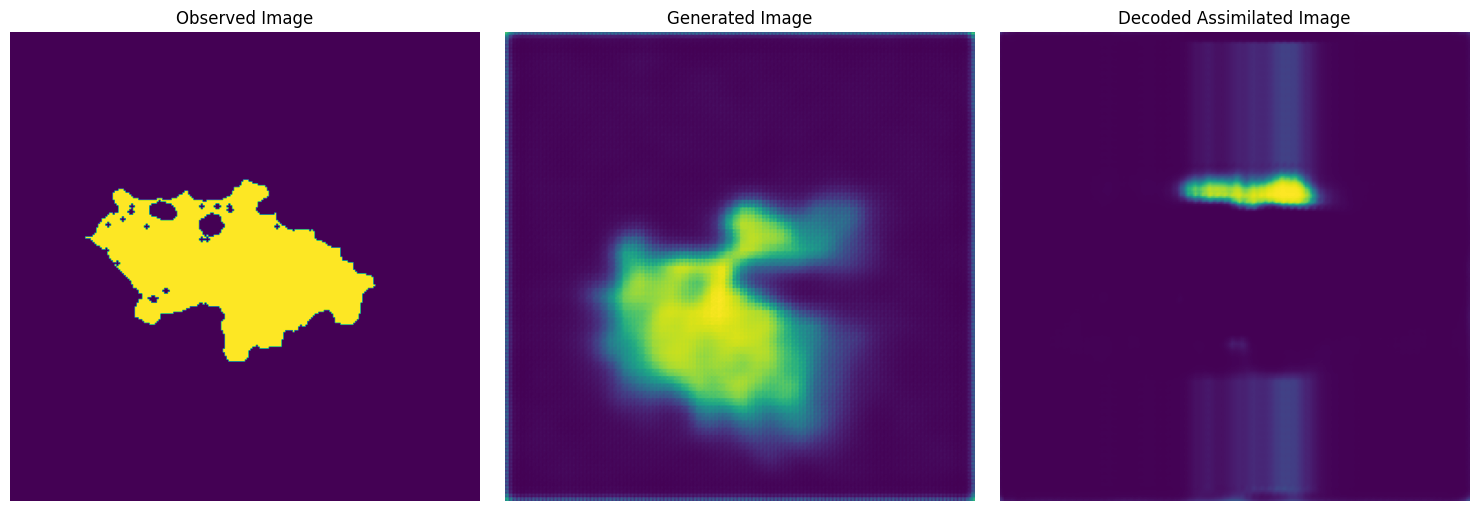

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Observed Image
axes[0].imshow(observed_image, cmap='viridis')
axes[0].set_title('Observed Image')
axes[0].axis('off')

# Generated Image
axes[1].imshow(generated_image, cmap='viridis')
axes[1].set_title('Generated Image')
axes[1].axis('off')

# Decoded Assimilated Image
decoded_image = decoded_assimilation[0, 0]  # Reshape decoded_assimilation if needed
axes[2].imshow(decoded_image, cmap='viridis')
axes[2].set_title('Decoded Assimilated Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()

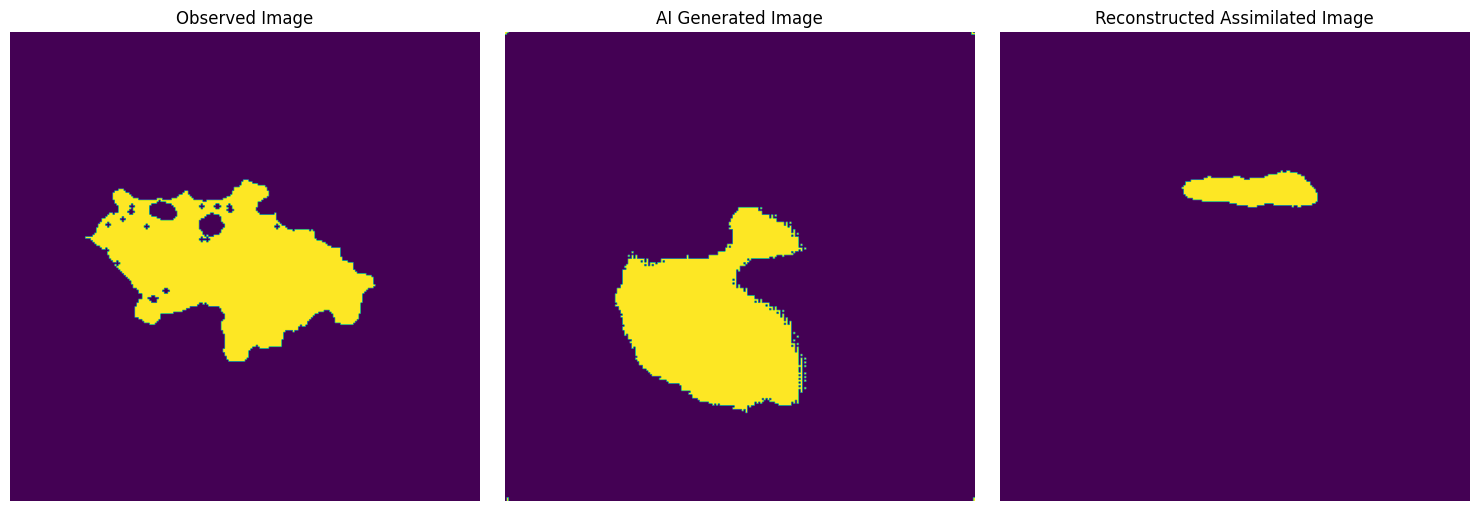

In [ ]:
threshold = 0.3

binary_observed_image = (observed_image > threshold).astype(int)
binary_generated_image = (generated_image > threshold).astype(int)
binary_decoded_image = (decoded_assimilation[0, 0] > threshold).astype(int)  # Reshape decoded_assimilation if needed

# Plot the images side by side for comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Binary Observed Image
axes[0].imshow(binary_observed_image, cmap='viridis')
axes[0].set_title('Observed Image')
axes[0].axis('off')

# Binary Generated Image
axes[1].imshow(binary_generated_image, cmap='viridis')
axes[1].set_title('AI Generated Image')
axes[1].axis('off')

# Binary Decoded Assimilated Image
axes[2].imshow(binary_decoded_image, cmap='viridis')
axes[2].set_title('Reconstructed Assimilated Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()